<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product ">
</a> 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0321EN-SkillsNetwork/image/IDSN-logo.png" width="200" alt="cognitiveclass.ai logo">


<h1><h1>Pre-trained-Models with PyTorch </h1>


In this lab, you will use pre-trained models to classify between the negative and positive samples; you will be provided with the dataset object. The particular pre-trained model will be resnet18; you will have three questions: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>
You will take several screenshots of your work and share your notebook. 


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
<p>Estimated Time Needed: <strong>120 min</strong></p>
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory, unlike the other labs, all the data will be deleted after you close  the lab, this may take some time:


In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2023-08-10 05:14:11--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  12.7MB/s    in 2m 2s   

2023-08-10 05:16:14 (20.3 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
!unzip -q Positive_tensors.zip 

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2023-08-10 05:18:00--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  23.3MB/s    in 94s     

2023-08-10 05:19:35 (21.3 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [4]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


 This dataset class is essentially the same dataset you build in the previous section, but to speed things up, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [7]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/wsuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [8]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Question 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [9]:
# Step 1: Load the pre-trained model resnet18

# Type your code here
model = models.resnet18(pretrained=True)

/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/Python-3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/wsuser/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [10]:
# Step 2: Set the parameter cannot be trained for the pre-trained model


# Type your code here
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [11]:
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2)  #(num_of_class == 2)
#model = model.to(device) 


Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Question 2: Train the Model</h2>


In this question you will train your, model:


<b>Step 1</b>: Create a cross entropy criterion function 


In [13]:
# Step 1: Create the loss function

# Type your code here
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [14]:

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100)


<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [15]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**


In [16]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)
start_time = time.time()
#n_epochs

Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        
        train_start_time = time.time()
        
        model.train()
        
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z=model(x)   
        # calculate loss 
        loss=criterion(z,y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
        
        print('Train iteration' , i+1, 'completed after ', time.time()-train_start_time, 'seconds')
        
    correct=0
    for i, (x_test, y_test) in enumerate(validation_loader):
        val_start_time = time.time()
        
        # set model to eval 
        model.eval()
        #make a prediction 
        z=model(x_test)
        #find max 
        _,yhat=torch.max(z.data,1)
        
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct+=(yhat==y_test).sum().item()
   
        print('Validation iteration' , i+1, 'completed after ', time.time()-val_start_time, 'seconds')
    
    accuracy=correct/N_test
    accuracy_list.append(accuracy)

    print('Epoch' , i+1, 'completed after ', time.time()-start_time, 'seconds')

Train iteration 1 completed after  15.32438611984253 seconds
Train iteration 2 completed after  15.841508150100708 seconds
Train iteration 3 completed after  15.084900379180908 seconds
Train iteration 4 completed after  14.969390869140625 seconds
Train iteration 5 completed after  15.170836448669434 seconds
Train iteration 6 completed after  15.064854860305786 seconds
Train iteration 7 completed after  15.273167610168457 seconds
Train iteration 8 completed after  15.074753284454346 seconds
Train iteration 9 completed after  15.062071800231934 seconds
Train iteration 10 completed after  15.266167163848877 seconds
Train iteration 11 completed after  14.880619525909424 seconds
Train iteration 12 completed after  14.880277872085571 seconds
Train iteration 13 completed after  15.058905601501465 seconds
Train iteration 14 completed after  14.762465715408325 seconds
Train iteration 15 completed after  14.836748838424683 seconds
Train iteration 16 completed after  15.027063131332397 seconds
Tr

Train iteration 132 completed after  15.048607110977173 seconds
Train iteration 133 completed after  15.031184673309326 seconds
Train iteration 134 completed after  14.941624641418457 seconds
Train iteration 135 completed after  15.369028091430664 seconds
Train iteration 136 completed after  14.808326005935669 seconds
Train iteration 137 completed after  15.094889402389526 seconds
Train iteration 138 completed after  15.131612300872803 seconds
Train iteration 139 completed after  15.051244735717773 seconds
Train iteration 140 completed after  15.055670976638794 seconds
Train iteration 141 completed after  15.517261505126953 seconds
Train iteration 142 completed after  15.152193784713745 seconds
Train iteration 143 completed after  14.794951677322388 seconds
Train iteration 144 completed after  15.136443376541138 seconds
Train iteration 145 completed after  15.179981708526611 seconds
Train iteration 146 completed after  15.468140125274658 seconds
Train iteration 147 completed after  15.

Train iteration 261 completed after  15.292502641677856 seconds
Train iteration 262 completed after  15.098190784454346 seconds
Train iteration 263 completed after  15.616907119750977 seconds
Train iteration 264 completed after  15.457191228866577 seconds
Train iteration 265 completed after  14.794814109802246 seconds
Train iteration 266 completed after  15.294975996017456 seconds
Train iteration 267 completed after  14.813938856124878 seconds
Train iteration 268 completed after  15.346344709396362 seconds
Train iteration 269 completed after  15.774659633636475 seconds
Train iteration 270 completed after  15.105914115905762 seconds
Train iteration 271 completed after  14.97592568397522 seconds
Train iteration 272 completed after  15.781502485275269 seconds
Train iteration 273 completed after  15.208431243896484 seconds
Train iteration 274 completed after  15.232578754425049 seconds
Train iteration 275 completed after  15.074676036834717 seconds
Train iteration 276 completed after  15.0

Validation iteration 93 completed after  14.691221475601196 seconds
Validation iteration 94 completed after  14.351034879684448 seconds
Validation iteration 95 completed after  14.550195693969727 seconds
Validation iteration 96 completed after  14.49656891822815 seconds
Validation iteration 97 completed after  14.444733381271362 seconds
Validation iteration 98 completed after  14.508371591567993 seconds
Validation iteration 99 completed after  14.309174299240112 seconds
Validation iteration 100 completed after  14.319646835327148 seconds
Epoch 100 completed after  6262.112065076828 seconds


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [17]:
accuracy

0.9936

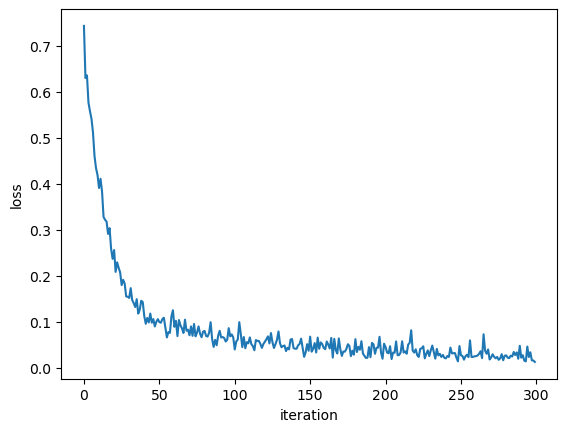

In [18]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<h2 id="Question_3">Question 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [ ]:

count = 0
validation_loader_ = torch.utils.data.DataLoader(validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate (validation_loader_):
    
    model.eval()
    
    z = model(x_test)
    
    _, yhat = torch.max(z, 1)
    
    if yhat != y_test:
        
        print("sample", i,' predicted value', yhat, ' actual value', y_test)
        
        count += 1
        if count >= 4:
            break       

sample 28  predicted value tensor([0])  actual value tensor([1])
sample 104  predicted value tensor([0])  actual value tensor([1])
sample 210  predicted value tensor([0])  actual value tensor([1])


In [24]:
count = 0
max_num_of_items = 4  # first four mis-classified samples
validation_loader_batch_one = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=1)

for i, (x_test, y_test) in enumerate(validation_loader_batch_one):
    # set model to eval
    model.eval()
    
    # make a prediction
    z = model(x_test)
    
    # find max
    _, yhat = torch.max(z.data, 1)
    
    # print mis-classified samples
    if yhat != y_test:
        print("Sample : {}; Expected Label: {}; Obtained Label: {}".format(str(i), str(y_test), str(yhat)))
        count += 1
        if count >= max_num_of_items:
            break
    # end if
# end for

Sample : 28; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 104; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 210; Expected Label: tensor([1]); Obtained Label: tensor([0])
Sample : 362; Expected Label: tensor([1]); Obtained Label: tensor([0])


<a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/share-notebooks.html?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01"> CLICK HERE </a> Click here to see how to share your notebook.


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.



## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |



<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>


In [ ]:
Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDL0321ENSkillsNetwork951-2022-01-01">MIT License</a>.
